In [1]:
from prod.set_seed import random_ctl
seed = random_ctl()

from fastai.text import *
from fastai.callbacks import SaveModelCallback
from fastai.layers import LabelSmoothingCrossEntropy

import sentencepiece as spm #https://github.com/google/sentencepiece
import fire

from prod.sp_tok import *
from prod.bin_metrics import Fbeta_binary

def split_rebal_data(all_texts_df:DataFrame, clas_col:str='is_humor', split_seed:int=None):
    ## rebalance cases
    print('Number of positive samples:', (all_texts_df.loc[:,clas_col] == 1).sum())
    print('Number of negative samples:',  (all_texts_df.loc[:,clas_col] == 0).sum())
    print('Total samples:', len(all_texts_df))

    if split_seed: np.random.seed(split_seed)
    idx = np.random.permutation(len(all_texts_df))
    test_cut = int(0.15 * len(idx))
    valid_cut = int(0.15 * len(idx-test_cut))

    df_train_all = all_texts_df.iloc[idx[:-(valid_cut+test_cut)],:]
    df_valid     = all_texts_df.iloc[idx[ -(valid_cut+test_cut):-test_cut],:]
    df_test      = all_texts_df.iloc[idx[-test_cut:],:]

    print('Test prevalence(n = %d):'%len(df_test),df_test.loc[:,clas_col].sum()/ len(df_test))
    print('Valid prevalence(n = %d):'%len(df_valid),df_valid.loc[:,clas_col].sum()/ len(df_valid))
    print('Train all prevalence(n = %d):'%len(df_train_all), df_train_all.loc[:,clas_col].sum()/ len(df_train_all))
    print('all samples (n = %d)'%len(all_texts_df))
    assert len(all_texts_df) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

    ## assumes that negative is less frequent case.  Generalize?
    rows_pos = df_train_all.loc[:,clas_col] == 1
    df_train_pos = df_train_all.loc[rows_pos]
    df_train_neg = df_train_all.loc[~rows_pos]
    print(f'Train Pos Cases:{df_train_pos.shape},Train Neg Cases:{df_train_neg.shape}')
    df_resample_pos = df_train_pos.sample(n=len(df_train_neg),replace=True,
                                          axis=0,random_state=np.random.get_state()[1][0]).reset_index(drop=True)
    df_train = pd.concat([df_resample_pos,df_train_neg],axis=0) #randomized again in DataBunch?
    print('Train prevalence (n = %d):'%len(df_train), df_train.loc[:,clas_col].sum()/ len(df_train))

    return df_train, df_valid, df_test

Using seed: 571845


In [2]:
model_path = './data/rnn'
sp_model = 'all_tweets_es_0609'
batch_size = 64
backward = 0
dropmult = 1.0
qrnn = True
n_hid:int=2304
flat_loss = True
enc_name = 'twitter_es_enc_QRNN_0609_drop1_seed0_finetune'

In [3]:
PATH = Path(model_path)
#torch.backends.cudnn.enabled=False

defaults.text_spec_tok.append(NL) #add a New Line special char
sp_vocab = Vocab( get_itos(sp_model) )
mycust_tok = CustomTokenizer(SPTokenizer, sp_model, pre_rules=default_rules)

train_text = pd.read_csv('./data/haha_2019_train.csv')#.loc[:,'text']
test_text = pd.read_csv('./data/haha_2019_test.csv')#.loc[:,'text']

raw_text = pd.concat([train_text.loc[:,'text'], test_text.loc[:,'text']],axis=0)

print("Default Rules:\n",[x.__name__ for x in default_rules],"\n\n")
for rule in default_rules: raw_text = raw_text.apply(lambda x: rule(str(x)))
all_texts_df = pd.DataFrame(raw_text)
all_texts_df.columns = ['new_text']

Default Rules:
 ['fixup', 'replace_rep', 'replace_wrep', 'deal_caps', 'spec_add_spaces', 'rm_useless_spaces', 'sub_nl'] 




In [4]:
all_texts = all_texts_df['new_text'].values.squeeze()
idx = np.random.permutation(len(all_texts))
cut = int(0.1 * len(idx))
train_df = pd.DataFrame({'text':all_texts[idx[cut:]], 'labels':[0] * (len(all_texts)-cut)}, columns=['labels','text'])
valid_df = pd.DataFrame({'text':all_texts[idx[:cut]], 'labels':[0] * cut}, columns=['labels','text'])
print(f'Train:{train_df.shape}, valid:{valid_df.shape}')

keyword_args = {'bs':batch_size}
data = TextLMDataBunch.from_df(PATH, train_df, valid_df, 
                               tokenizer=mycust_tok, vocab=sp_vocab,
                               text_cols='text', label_cols='labels', backwards=backward,
                               **keyword_args)

In [5]:
data.show_batch()

idx,text
0,"▁hay ▁dolor ▁, ▁comple mentas ▁mi ▁existir ▁ xxbos ▁ xxrep ▁5 ▁a ▁bor to ▁leg ▁ xxrep ▁4 ▁a ▁l ▁, ▁ee en ▁el ▁hos pita a al ▁ xxbos ▁hablar ▁horas ▁con ▁una ▁persona ▁y ▁no ▁abur rir se . ▁ xxbos ▁- ▁¿ ▁algún ▁fiscal ▁vivo ▁en ▁la ▁sala ▁? ▁xxnl ▁- ▁continuamos ▁para ▁b ingo ▁ xxbos ▁me ▁tengo ▁que ▁levantar ▁a ▁las ▁seis . ▁desde"
1,"▁hacerlo ▁, ▁# ▁yo tras man eras de enamor arme ▁ xxbos ▁como ▁es ▁que ▁le ▁puede ▁gustar ▁el ▁invierno ▁! ▁ xxunk ▁ xxbos ▁me ▁puse ▁a ▁rea como dar ▁mis ▁pós ters ▁de ▁exo ▁y ▁a ▁poner los ▁en ▁cuadros ▁y ▁estoy ▁in ▁love ▁por ▁como ▁se ▁ven ▁ xxbos ▁yo ▁también ▁le ▁anular ía ▁todos ▁los ▁goles ▁a ▁méxico ▁cuando ▁se ▁presenta ▁a ▁un ▁mundial ▁disfrazado ▁con"
2,"▁la ▁chingada . ▁nos ▁vemos ▁en ▁misa ▁a ▁las ▁7:00 ▁am . ▁ xxbos ▁me ▁tom aste ▁de ▁la ▁mano ▁para ▁siempre . ▁ xxbos ▁— comp adre ▁, ▁¡ vá monos ▁de ▁putas ▁! ▁xxnl ▁—¿ qué ▁, ▁a poco ▁traes ▁dinero ▁? ▁xxnl ▁—¿ qué ▁, ▁a poco ▁me ▁vas ▁a ▁cobrar ▁? ▁ xxbos ▁la ▁lluvia ▁siempre ▁siempre ▁me ▁depri me ▁ xxbos ▁fui ▁a ▁robar ▁el"
3,"▁baby ▁ xxrep ▁4 ▁. ▁te ▁regalo ▁vegetales ▁si ▁te ▁mandas ▁este ▁hot dog ▁ xxbos ▁es ▁fácil ▁identificar ▁a ▁un ▁pendejo ▁cuando ▁usa ▁frases ▁como ▁« c ás ate ▁conmigo ▁inter ner » ▁o ▁« inter net ▁, ▁nunca ▁nos ▁dejes ». ▁putos ▁retras ados ▁de ▁mierda ▁ xxbos ▁ xxup ▁advertencia : ▁el ▁consumo ▁de ▁alcohol ▁puede ▁hacerle ▁pensar ▁que ▁es ▁experto ▁en ▁k ung ▁fu . ▁#"
4,"▁martes : ▁"" oh ▁dios ▁! ▁"" ▁miercoles : ▁"" a ▁la ▁mitad ▁! ▁"" ▁jueves : ▁"" ya ▁casi ▁! ▁"" ▁viernes : ▁"" por ▁fin ▁! ▁"" ▁sábado : ▁"" si ii ▁! ▁"" ▁domingo : ▁"" n ▁ xxrep ▁6 ▁o ▁"" ▁ xxbos ▁cantar ▁canciones ▁en ▁ingles ▁con ▁palabras ▁que ▁ni ▁existen ▁ xxbos ▁están ▁pin tando ▁mi ▁casa ▁y ▁no ▁puedo ▁andar ▁en ▁ropa ▁cómoda"


In [6]:
config = awd_lstm_lm_config.copy()
config['qrnn'] = qrnn
config['n_hid'] = n_hid
print(config)
learn = language_model_learner(data, AWD_LSTM, drop_mult=dropmult, pretrained=False, config=config)
if flat_loss: learn.loss_func = FlattenedLoss(LabelSmoothingCrossEntropy)
print(learn.model)

''' -rw-rw-r-- 1 farzin farzin 185M Jun  6 17:34 twitter_es_enc_QRNN_0606_seed1.pth
    -rw-rw-r-- 1 farzin farzin 553M Jun  6 17:34 twitter_es_118990.pth  '''
_ = learn.load('twitter_es_504940')  #load the LM, finetune from here
#./data/rnn/models/twitter_es_504940.pth

{'emb_sz': 400, 'n_hid': 2304, 'n_layers': 3, 'pad_token': 1, 'qrnn': True, 'bidir': False, 'output_p': 0.1, 'hidden_p': 0.15, 'input_p': 0.25, 'embed_p': 0.02, 'weight_p': 0.2, 'tie_weights': True, 'out_bias': True}
SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(30000, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(30000, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): QRNN(
        (layers): ModuleList(
          (0): QRNNLayer(
            (linear): WeightDropout(
              (module): Linear(in_features=800, out_features=6912, bias=True)
            )
          )
        )
      )
      (1): QRNN(
        (layers): ModuleList(
          (0): QRNNLayer(
            (linear): WeightDropout(
              (module): Linear(in_features=2304, out_features=6912, bias=True)
            )
          )
        )
      )
      (2): QRNN(
        (layers): ModuleList(
          (0): QRNNLayer(
            (linear): WeightDropout(
        

In [7]:
total_params = sum(p.numel() for p in learn.model.parameters() if p.requires_grad)
f'{total_params:,}'

'60,484,320'

In [8]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


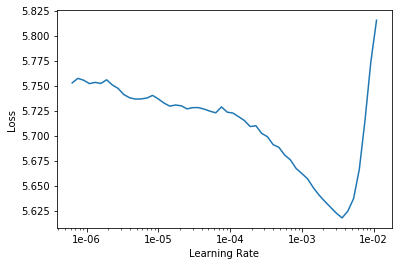

In [9]:
learn.recorder.plot(skip_end=25)

In [10]:
learn.fit_one_cycle(5, 3e-3, moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,5.330932,5.164488,0.283426,00:23
1,5.198107,5.114437,0.293080,00:23
2,4.982135,5.058008,0.302134,00:23
3,4.748193,5.032469,0.307994,00:23
4,4.573133,5.035619,0.309668,00:23


In [11]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-4, moms=(0.7,0.6), wd=0.1, pct_start=0.2)

epoch,train_loss,valid_loss,accuracy,time
0,4.550231,5.039394,0.309891,00:23
1,4.543684,5.038823,0.310128,00:23
2,4.534138,5.039264,0.310589,00:23
3,4.522259,5.040609,0.310603,00:23
4,4.504599,5.041269,0.310645,00:23
5,4.499281,5.041697,0.310617,00:23
6,4.485062,5.043220,0.310156,00:23
7,4.476281,5.043169,0.310714,00:23
8,4.478516,5.043724,0.310603,00:23
9,4.476860,5.043563,0.310407,00:23


In [12]:
learn.save_encoder(enc_name)

In [13]:
learn.save(f"twitter_es_finetune_{seed}{'_bwd' if backward else ''}")